###This notebook trains a classifier to predict the terns type. The training data are taken from Yolo model output. We train vaious different classifiers and choose the one with the best performance. Firstly, we run a Yolo model on images which are already annotated. After that, we matched between the annotated box and a tracked sequence of boxes(Represents a tern from different sequential images). Then, we used the boxes sequence of the tracked tern as a resource for our advanced features.

Features(X):
 * tern-categories statistics according to the flag location.
 * Tern size in CM(The average of the boxes sequence).
 * Yolo predictions of the tracked tern.

Target(Y):
* Tern label

In [1]:
import os
import re
import json
import glob
import numpy as np
import pandas as pd

In [2]:
import os

dir = '/content/drive/MyDrive/tern_project/Eyal/ClassifyTerns/TrainingModel'

os.chdir(dir)

### Read parameters from config file

In [3]:
import configparser

# Initialize the ConfigParser object
config = configparser.ConfigParser()
# Read the INI file
config.read('train_classifier.ini')
# Tagged images width
image_width = int(config.get('General', 'image_width'))
# Tagged images height
image_height = int(config.get('General', 'image_height'))
# Annotated images directory
annotated_images_dir = config.get('General', 'annotated_images_dir')
# Tracking results dir of all tours scans
tracking_results_dir = config.get('General', 'tracking_results_dir')

Read results of tracking terns of two tours where the annotations took from:
* camera 191 - 29.6.2023 - tour0
* camera 181 - 14.7.2023 - tour0

In [4]:
tracking_res_tour_dir = {
    '191': f'{tracking_results_dir}/OneScanTracks/atlitcam191.stream_2023_06_29_05_30_00/tour0',
    '181': f'{tracking_results_dir}/OneScanTracks/atlitcam181.stream_2023_07_14_15_00_00/tour0'
}

Read annotations files

In [5]:
annotations_dict = {
    '181': [filename for filename in os.listdir(f'{annotated_images_dir}/181') if filename.endswith(".txt")],
    '191': [filename for filename in os.listdir(f'{annotated_images_dir}/191') if filename.endswith(".txt")]
}

In [6]:
images_number = len(annotations_dict['181']) + len(annotations_dict['191'])
print(f'Tagged Images Number - {images_number}')

Tagged Images Number - 111


In [7]:
# This function takes annotations text in YOLO format(with relative values) and convert to regular coordinates
def convert_annotation_into_coordinate(annotation):
    anno_class, x, y, width, height = map(float, annotation.split())

    # Calculate values in regular coordinates
    return {
        'class': int(anno_class),
        'x1': float((x - width / 2) * image_width),
        'y1': float((y - height / 2) * image_height),
        'x2': float((x + width / 2) * image_width),
        'y2': float((y + height / 2) * image_height)
    }

In [8]:
def get_flag_number(file_name):
    # Define a regular expression pattern to match the flag number
    pattern = r'flag(\d+)_'
    # Use re.search to find the pattern in the file name
    match = re.search(pattern, file_name)
    # Check if a match is found
    if match:
        # Extract the flag number from the matched group
        return match.group(1)
    else:
        print("No flag number found in the file name.")

In [9]:
def calculate_iou(box1, box2):
    # Extracting box1 coordinates
    x1 = box1['x1']
    y1 = box1['y1']
    x1_max = box1['x2']
    y1_max = box1['y2']

    # Calculating box1 width and height
    w1 = x1_max - x1
    h1 = y1_max - y1

    # Extracting box2 coordinates
    x2 = box2['x1']
    y2 = box2['y1']
    x2_max = box2['x2']
    y2_max = box2['y2']

    # Calculating box1 width and height
    w2 = x2_max - x2
    h2 = y2_max - y2

    # Calculating the coordinates of the intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    x_intersection_max = min(x1_max, x2_max)
    y_intersection_max = min(y1_max, y2_max)

    # Calculating the area of intersection
    intersection_area = max(0, x_intersection_max - x_intersection) * max(0, y_intersection_max - y_intersection)

    # Calculating the area of union
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area

    # Calculating the IoU
    iou = intersection_area / union_area

    return iou

In [10]:
def calc_similarity_box_vs_tracked_object(tracked_object, annotation_box, image_num):
    # Find the box from sequence that took from the same image of the annotation
    tracked_object_boxes = [box_pred for box_pred in tracked_object['predictions'] if f'_{image_num}_atlitcam' in box_pred['image_path']]

    # It could be that YOLO didn't succeed to detect the annotation box and then there is no box in the tracked object box sequence
    if len(tracked_object_boxes) != 1:
        return 0
    tracked_object_box = tracked_object_boxes[0]

    return calculate_iou(tracked_object_box['box'], annotation_box)

Read statistics distribution of terns type in flags

In [11]:
# Labels distribution of flags path
labels_distribution_in_flags_path = '/content/drive/MyDrive/tern_project/Eyal/LabelsDistributionInFlags/labels_distribution_by_yolo_updated.json'
# Read labels distribution file
with open(labels_distribution_in_flags_path, 'r') as json_file:
    labels_distribution_in_flags_json = json.load(json_file)

# Display the first few lines of the JSON content
for i, (key, value) in enumerate(labels_distribution_in_flags_json.items()):
    print(key, value)
    if i == 3:
        break

4 {'Little-Stand': 0, 'Little-Sit': 0.29244808658910104, 'Common-Stand': 0.5669390274895842, 'Common-Sit': 99.14061288592131, 'Common-Fly': 0, 'Little-Fly': 0, 'Common-Stand-Tag': 0, 'Little-Stand-Tag': 0, 'Chick': 0, 'Other': 0}
24 {'Little-Stand': 0, 'Little-Sit': 0.6459420577439776, 'Common-Stand': 5.757713775924624, 'Common-Sit': 93.5963441663314, 'Common-Fly': 0, 'Little-Fly': 0, 'Common-Stand-Tag': 0, 'Little-Stand-Tag': 0, 'Chick': 0, 'Other': 0}
25 {'Little-Stand': 0, 'Little-Sit': 5.851566808555579, 'Common-Stand': 0.15662861081312188, 'Common-Sit': 93.9918045806313, 'Common-Fly': 0, 'Little-Fly': 0, 'Common-Stand-Tag': 0, 'Little-Stand-Tag': 0, 'Chick': 0, 'Other': 0}
26 {'Little-Stand': 0, 'Little-Sit': 16.455371816634585, 'Common-Stand': 0.21135178774633928, 'Common-Sit': 83.33327639561907, 'Common-Fly': 0, 'Little-Fly': 0, 'Common-Stand-Tag': 0, 'Little-Stand-Tag': 0, 'Chick': 0, 'Other': 0}


In [12]:
def get_image_number(file_name):
    # Define the pattern to match the image number
    pattern = r'_\d+_atlitcam'

    # Use regular expression to find the match
    match = re.search(pattern, file_name)

    if match:
        # Extract the image number from the matched substring
        image_number = int(match.group(0).split('_')[1])
    return image_number

In [13]:
def calcAverageCoordinate(predictions):
    x1, x2, y1, y2 = 0, 0, 0, 0

    for prediction in predictions:
        x1 += prediction['box']['x1']
        x2 += prediction['box']['x2']
        y1 += prediction['box']['y1']
        y2 += prediction['box']['y2']

    return { 'x1': x1 / len(predictions), 'y1': y1 / len(predictions), 'x2': x2 / len(predictions), 'y2': y2 / len(predictions) }

In [14]:
def sumClassesPrediction(predictions):
    classes_prediction = {
        "Little-Stand": {'freq': 0, 'conf': 0},
        "Little-Sit": {'freq': 0, 'conf': 0},
        "Common-Stand": {'freq': 0, 'conf': 0},
        "Common-Sit": {'freq': 0, 'conf': 0},
        "Common-Fly": {'freq': 0, 'conf': 0},
        "Little-Fly": {'freq': 0, 'conf': 0},
        "Common-Stand-Tag": {'freq': 0, 'conf': 0},
        "Little-Stand-Tag": {'freq': 0, 'conf': 0},
        "Chick": {'freq': 0, 'conf': 0},
        "Other": {'freq': 0, 'conf': 0}
    }

    for prediction in predictions:
        classes_prediction[prediction["name"]]['freq'] += 1
        classes_prediction[prediction["name"]]['conf'] += prediction['confidence']

    for key in classes_prediction.keys():
        classes_prediction[key]['conf'] = (classes_prediction[key]['conf'] / classes_prediction[key]['freq']) if classes_prediction[key]['freq'] > 0 else 0
        classes_prediction[key]['freq'] /= len(predictions)
        flat_classes_prediction = {}

    for key, value in classes_prediction.items():
        for sub_key, sub_value in value.items():
            new_key = key + '_y_' + sub_key
            flat_classes_prediction[new_key] = sub_value

    return flat_classes_prediction

In [15]:
# This function seeks for best match of an annotation with list of predictions boxes
def find_match_tracked_objects_vs_annotation(tracked_objects, annotated_box, image_number):
    best_obj_index = None
    best_iou = 0

    for i, tracked_object in enumerate(tracked_objects):
        iou = calc_similarity_box_vs_tracked_object(tracked_object, annotated_box, image_number)
        if iou > best_iou:
            best_iou = iou
            best_obj_index = i

    return best_obj_index, best_iou

### Create a dataframe of tracked terns with true labels.

In [16]:
classes = ["Little-Stand", "Little-Sit", "Common-Stand", "Common-Sit", "Common-Fly", "Little-Fly", "Common-Stand-Tag", "Little-Stand-Tag", "Chick", "Other"]

boxes_details_list = []

IOU_SIMILARITY_THRESHOLD = 0.5

for cam_annotation in annotations_dict.keys():
    for annotation_file_name in annotations_dict[cam_annotation]:
        # Extract the flag number from file name
        flag_number = get_flag_number(annotation_file_name)
        # Get tern classes distribution
        flag_labels_distribution = labels_distribution_in_flags_json[flag_number]
        tracking_result_name = f'{tracking_res_tour_dir[cam_annotation]}/flag{flag_number}.json'

        if not os.path.exists(tracking_result_name):
            continue
        # Open the tracking result JSON file of a flag
        with open(tracking_result_name, 'r') as file:
            tracking_result_report = json.load(file)

        tracked_objects = tracking_result_report["object_boxes"]
        txt_file_path = f'{annotated_images_dir}/{cam_annotation}/{annotation_file_name}'
        # Read image annotations
        with open(txt_file_path, 'r') as txt_file:
            image_annotations = txt_file.read()
        # Convert image annotations string to a regular coordinates boxes
        annotations_list = image_annotations.strip().split('\n')
        annotations_list = [convert_annotation_into_coordinate(annotation) for annotation in annotations_list]

        # Get the image number from the file name
        image_number = get_image_number(txt_file_path)

        for annotation_box in annotations_list:

            # Find the tracked object that match the object in the box(by calculating boxes IOU)
            index, iou = find_match_tracked_objects_vs_annotation(tracked_objects, annotation_box, image_number)

            # If there is no boxes sequence with high similarity to the annotated box then we ignore the box
            if iou < IOU_SIMILARITY_THRESHOLD:
                continue

            box_details = {
                **(calcAverageCoordinate(tracked_objects[index]['predictions'])),
                **(sumClassesPrediction(tracked_objects[index]['predictions'])),
                **flag_labels_distribution,
                'detection_rate': len(tracked_objects[index]['predictions']) / tracking_result_report['frames_number'],
                'movement_rate': tracked_objects[index]['iou'],
                'flag': flag_number,
                'y': classes[annotation_box['class']],
                'path': tracking_result_name
            }

            boxes_details_list.append(box_details)

# Create dataframe for store boxes details
boxes_details_df = pd.DataFrame(boxes_details_list)

In [17]:
boxes_details_df.head()

,x1,y1,x2,y2,Little-Stand_y_freq,Little-Stand_y_conf,Little-Sit_y_freq,Little-Sit_y_conf,Common-Stand_y_freq,Common-Stand_y_conf,...,Little-Fly,Common-Stand-Tag,Little-Stand-Tag,Chick,Other,detection_rate,movement_rate,flag,y,path
0,0.000000,70.620063,76.394909,143.691397,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,1.000000,0.933112,138,Common-Sit,/content/drive/MyDrive/tern_project/Eyal/Track...
1,239.673098,189.569885,296.592215,250.163775,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,0.636364,0.957180,138,Common-Sit,/content/drive/MyDrive/tern_project/Eyal/Track...
2,648.610057,506.413286,833.531932,605.156072,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,1.000000,0.931250,138,Common-Sit,/content/drive/MyDrive/tern_project/Eyal/Track...
3,856.792813,55.826141,921.949907,145.910803,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,1.000000,0.972715,138,Common-Sit,/content/drive/MyDrive/tern_project/Eyal/Track...
4,1079.601596,222.164744,1146.011397,298.134843,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0.0,1.000000,0.885306,138,Common-Sit,/content/drive/MyDrive/tern_project/Eyal/Track...


### Found tracked sequences that Yolo detect it falsly(without any terns on it) and label it as 'Background' class.

In [18]:
def find_match_tracked_object_vs_annotations(tracked_object, annotations_list, image_num):
    # Find the box from sequence that took from the same image of the annotation
    tracked_object_boxes = [box_pred for box_pred in tracked_object['predictions'] if f'_{image_num}_atlitcam' in box_pred['image_path']]

    best_obj_index = -1
    best_iou = -1
    # It could be that YOLO didn't succeed to detect the annotation box and then there is no box in the tracked object box sequence
    if len(tracked_object_boxes) != 1:
        return best_obj_index, best_iou
    tracked_object_box = tracked_object_boxes[0]

    for i, annotated_box in enumerate(annotations_list):
        iou = calculate_iou(tracked_object_box['box'], annotated_box)
        if iou > best_iou:
            best_iou = iou
            best_obj_index = i

    return best_obj_index, best_iou

In [19]:
def isEdgeCuttedTrack(background_track_details):
    if ((background_track_details['x1'] < 1 and background_track_details['x2'] - background_track_details['x1'] < 100) or
        (background_track_details['x2'] > 1279 and background_track_details['x2'] - background_track_details['x1'] < 100)):
        return False
    else:
        return True

In [20]:
ious = []
backgrounds_sequences = []
for cam_annotation in annotations_dict.keys():
    for annotation_file_name in annotations_dict[cam_annotation]:
        # Extract the flag number from file name
        flag_number = get_flag_number(annotation_file_name)
        # Get tern classes distribution
        flag_labels_distribution = labels_distribution_in_flags_json[flag_number]

        tracking_result_name = f'{tracking_res_tour_dir[cam_annotation]}/flag{flag_number}.json'
        if not os.path.exists(tracking_result_name):
            continue
        # Open the tracking result JSON file of a flag
        with open(tracking_result_name, 'r') as file:
            tracking_result_report = json.load(file)

        tracked_objects = [tracked_object for tracked_object in tracking_result_report["object_boxes"]  if len(tracked_object['predictions']) > 3]
        txt_file_path = f'{annotated_images_dir}/{cam_annotation}/{annotation_file_name}'

        # Read image annotations
        with open(txt_file_path, 'r') as txt_file:
            image_annotations = txt_file.read()

        # Convert image annotations string to a regular coordinates boxes
        annotations_list = image_annotations.strip().split('\n')
        annotations_list = [convert_annotation_into_coordinate(annotation) for annotation in annotations_list]

        # Get the image number from the file name
        image_num = get_image_number(txt_file_path)

        for tracked_object in tracked_objects:
            index, iou = find_match_tracked_object_vs_annotations(tracked_object, annotations_list, image_num)
            if iou > 0.05 or iou == -1:
                continue
            ious.append(iou)
            box_details = {
                **(calcAverageCoordinate(tracked_object['predictions'])),
                **(sumClassesPrediction(tracked_object['predictions'])),
                **flag_labels_distribution,
                'detection_rate': len(tracked_object['predictions']) / tracking_result_report['frames_number'],
                'movement_rate': tracked_object['iou'],
                'flag': flag_number,
                'y': 'Background',
                'path': tracking_result_name,
            }
            box_details['isLegal'] = isEdgeCuttedTrack(box_details)
            backgrounds_sequences.append(box_details)

# Create dataframe of the background class boxes
backgrounds_df = pd.DataFrame(backgrounds_sequences)

### Search all tracked sequences which have no suited match of annotated box. Consider those tracked sequences as a false detections of Yolo. Hence, Those tracked tag as Background class and added for train.

In [21]:
import os
import shutil

# Define the directory path
backgrounds_tracked_objects_dir = '/content/drive/MyDrive/tern_project/Eyal/ClassifyTerns/TrainingModel/backgrounds_tracked_objects'

# Check if the directory exists
if os.path.exists(backgrounds_tracked_objects_dir):
    # If it exists, delete it and its contents
    shutil.rmtree(backgrounds_tracked_objects_dir)

# Create the directory if it doesn't exist
os.makedirs(backgrounds_tracked_objects_dir, exist_ok=True)

In [22]:
import cv2
import shutil

images_dirs = [
    '/content/drive/MyDrive/tern_project/Eyal/ClassifyTerns/TrainingModel/Dataset/181/{s}_6_atlitcam181.stream_2023_07_14_15_00_00.jpg',
    '/content/drive/MyDrive/tern_project/Eyal/ClassifyTerns/TrainingModel/Dataset/191/{s}_7_atlitcam191.stream_2023_06_29_05_30_00.jpg'
]

for index, row in backgrounds_df.iterrows():
    # Get the base filename from the path
    filename = os.path.basename(row['path'])
    # Get the filename without extension
    filename = os.path.splitext(filename)[0]
    # If image exist in any images dir then copy it to the tracked backgrounds images dir
    for images_dir in images_dirs:
        # Format the string by replacing {s} with the replacement string
        image_path = images_dir.format(s=filename)
        # Check if the image exists
        if os.path.exists(image_path):
            # Construct the destination path
            destination_path = os.path.join(backgrounds_tracked_objects_dir, os.path.basename(image_path))

            if not os.path.exists(destination_path):
                # Copy the image to the new directory
                shutil.copy(image_path, destination_path)

            # break if the image not found in images dirs
            # if not os.path.exists(destination_path):
            #     break
            # Open the copied image using OpenCV
            img = cv2.imread(destination_path)

            color = (0, 255, 0) if row['isLegal'] else (220, 20, 60)
            image = cv2.rectangle(img, (int(row['x1']), int(row['y1'])), (int(row['x2']), int(row['y2'])), color, 2)

            # Save the modified image
            cv2.imwrite(destination_path, img)

### Remove background class samples that located at edges of the images

In [23]:
EdgeBackgroundsPercent = len(backgrounds_df[backgrounds_df['isLegal'] == False]) / len(backgrounds_df)

print(f'Edged backgrounds to remove: {EdgeBackgroundsPercent:.2f}')

Edged backgrounds to remove: 0.44


In [24]:
# Filter rows with True value in column1
backgrounds_df = backgrounds_df[backgrounds_df['isLegal'] == True]

# Delete column1
backgrounds_df = backgrounds_df.drop(columns=['isLegal'])

### Add tracked sequences of Background class to the general tagged sequences Dataframe.

In [25]:
boxes_details_df = pd.concat([backgrounds_df, boxes_details_df], ignore_index=True)

In [26]:
print(f'Annotations number used for training - {len(boxes_details_df)}')

Annotations number used for training - 1793


Drop columns of terns class distribution that are not helpful as inputs for our model.


*   Chick
*   Common-Fly
*   Little-Fly
*   Common-Stand-Tag
*   Little-Stand-Tag

Also we change the distribution class names to more informative one


In [27]:
import pandas as pd

boxes_details_df = boxes_details_df.drop(columns=['Chick', 'Common-Fly','Little-Fly','Common-Stand-Tag', 'Little-Stand-Tag'])

boxes_details_df = boxes_details_df.rename(columns={
    'Little-Stand': 'Little-Stand_f_freq',
    'Little-Sit': 'Little-Sit_f_freq',
    'Common-Stand': 'Common-Stand_f_freq',
    'Common-Sit': 'Common-Sit_f_freq',
    'Other': 'Other_f_freq',
})

### Calculating for each box the width and heigh size in cm. The calculations involve camera calibration, 3D to 2D transformations, and the use of PTZ (Pan-Tilt-Zoom) camera parameters. It's done by using a library writted to mapping box pixel coordinates into real world location.

In [28]:
import sys

sys.path.append('/content/drive/MyDrive/tern_project/Eyal/RealCoordinatesCalculator')
from real_coordinates_calculator import RealCoordinatesCalculator


real_coordinates_calculator = RealCoordinatesCalculator()
# Group by 'flag' and apply the box size calculation function
boxes_size_df = boxes_details_df.groupby('flag').apply(real_coordinates_calculator.calc_box_size)

Loading file /content/drive/MyDrive/tern_project/Eyal/RealCoordinatesCalculator/PTZCamValues181_mod.txt...
Loading file /content/drive/MyDrive/tern_project/Eyal/RealCoordinatesCalculator/PTZCamValues191_mod.txt...


<ipython-input-28-e83dfae5ed51>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  boxes_size_df = boxes_details_df.groupby('flag').apply(real_coordinates_calculator.calc_box_size)


In [29]:
# Prepare boxes_dize_df to the merge
boxes_size_df = boxes_size_df.reset_index()
boxes_size_df = boxes_size_df.drop(columns=['flag'])
boxes_size_df = boxes_size_df.rename(columns={'level_1': 'index'})
# Prepare nests_details_df to the merge
boxes_details_df = boxes_details_df.reset_index()
# Merge datafrmaes by index
boxes_details_df = pd.merge(boxes_details_df, boxes_size_df, on='index')

Map terns with rings categories to stand terns of the same type category:

*   (Common with rings -> Common stand)
*   (Little with rings -> Common stand)

In [30]:
mapping = {'Common-Stand-Tag': 'Common-Stand', 'Little-Stand-Tag': 'Little-Stand'}
boxes_details_df['y'] = boxes_details_df['y'].replace(mapping)

In [31]:
print('Labels distriution:')
boxes_details_df['y'].value_counts()

Labels distriution:


,count
y,
Common-Sit,1431
Common-Stand,221
Little-Sit,84
Background,38
Chick,12
Little-Stand,3
Common-Fly,2
Other,2


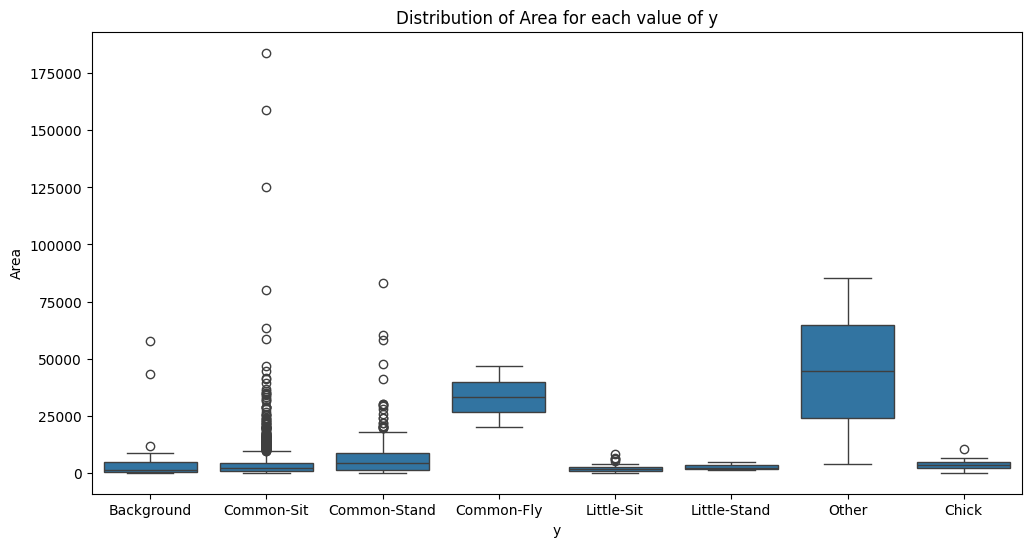

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 6))  # Adjust the width as needed

# Assuming your dataframe is called df
sns.boxplot(x='y', y='Area', data=boxes_details_df)
plt.xlabel('y')
plt.ylabel('Area')
plt.title('Distribution of Area for each value of y')

plt.xticks()

plt.show()

In [33]:
# Assuming boxes_details_df is your DataFrame
boxes_details_df[['y', 'DX_cm', 'DY_cm', 'Area']].to_csv('output.csv', index=False)

In [ ]:
boxes_details_df.head()

,index,x1,y1,x2,y2,Little-Stand_y_freq,Little-Stand_y_conf,Little-Sit_y_freq,Little-Sit_y_conf,Common-Stand_y_freq,...,dy/dx_uv,pix_x1,pix_y1,pix_x2,pix_y2,DX_cm,DY_cm,dx_pix_drone,dy_pix_drone,Area
0,0,428.555330,92.156791,471.884322,129.530152,0.0,0.0,0.0,0.0,0.0,...,0.862549,7831,14931,8042,14851,117.198892,101.089741,211,80,11847.605609
1,1,1035.786285,212.969086,1063.435944,234.713425,0.0,0.0,0.0,0.0,0.0,...,0.786423,8318,13874,8420,13853,56.390168,44.346550,102,21,2500.709403
2,2,0.000000,356.879512,230.840312,719.995200,0.0,0.0,0.0,0.0,0.0,...,1.573017,13376,14044,13283,13772,51.883002,81.612834,93,272,4234.318853
3,3,746.855026,31.574591,779.822281,55.216160,0.0,0.0,0.0,0.0,0.0,...,0.717123,9172,12463,9360,12480,104.305744,74.800025,188,17,7802.072218
4,4,1051.856333,205.298086,1084.228058,234.655306,0.0,0.0,0.0,0.0,0.0,...,0.906879,8391,18722,8569,18497,98.701745,89.510491,178,225,8834.841619


In [ ]:
import pandas as pd

# Assuming df is already defined or loaded
# Select specific columns
columns_to_save = ['y', 'DX_cm', 'DY_cm', 'Area']
filtered_df = boxes_details_df[columns_to_save]

# Save to CSV
output_file = 'size_details.csv'
filtered_df.to_csv(output_file, index=False)

print(f"Size data has been saved to {output_file}")

Size data has been saved to size_details.csv


## Perform Grid Search on various classifiers, Select Best Hyperparameters, and Evaluate Using Cross-Validation

Select the box columns we want to use as input for the classifier.

In [ ]:
from sklearn.utils import class_weight
from sklearn.model_selection import KFold

selected_features = [
    'Little-Stand_y_freq', 'Little-Stand_y_conf',
    'Little-Sit_y_freq', 'Little-Sit_y_conf', 'Common-Stand_y_freq',
    'Common-Stand_y_conf', 'Common-Sit_y_freq', 'Common-Sit_y_conf',
    'Common-Fly_y_freq', 'Common-Fly_y_conf', 'Little-Fly_y_freq',
    'Little-Fly_y_conf', 'Common-Stand-Tag_y_freq',
    'Common-Stand-Tag_y_conf', 'Little-Stand-Tag_y_freq',
    'Little-Stand-Tag_y_conf', 'Chick_y_freq', 'Chick_y_conf',
    'Other_y_freq', 'Other_y_conf', 'Little-Stand_f_freq',
    'Little-Sit_f_freq', 'Common-Stand_f_freq', 'Common-Sit_f_freq',
    'Other_f_freq', 'detection_rate', 'movement_rate', 'DX_cm', 'DY_cm', 'Area'
]

target = 'y'

# target is the name of the target column
X = boxes_details_df[selected_features]
y = boxes_details_df[target]

In [ ]:
y.value_counts()

,count
y,
Common-Sit,1431
Common-Stand,221
Little-Sit,84
Background,38
Chick,12
Little-Stand,3
Common-Fly,2
Other,2


In [ ]:
# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

# Define hyperparameter grid for tuning
param_grid = {
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_split': [2, 5, 7]
}

### Train Decision Tree without class weights

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier


decisionTreeClassifier = DecisionTreeClassifier()

# Use StratifiedKFold for cross-validation within GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(decisionTreeClassifier, param_grid, cv=cv, scoring='f1_macro')

# Fit the GridSearchCV with cross-validation
grid_search.fit(X, y)

# Get the best model from GridSearchCV
dt_classifier = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# Get the best model from GridSearchCV
dt_classifier = grid_search.best_estimator_

# Display the best hyperparameters
best_hypers = dt_classifier.get_params()
print(f'Hyperparameters: max_depth - {best_hypers["max_depth"]}, min_samples_split - {best_hypers["min_samples_split"]}')

Hyperparameters: max_depth - 5, min_samples_split - 2


In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix


# Initialize variables to accumulate results
all_predictions = np.array([])
all_true_values = np.array([])

dt_classifier = DecisionTreeClassifier(max_depth=best_hypers["max_depth"], min_samples_split=best_hypers["min_samples_split"])

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the decisionTreeClassifier
    dt_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = dt_classifier.predict(X_test)

    # Accumulate the results
    all_predictions = np.concatenate([all_predictions, y_pred])
    all_true_values = np.concatenate([all_true_values, y_test])

Confusion Matrix result after Cross-Validation

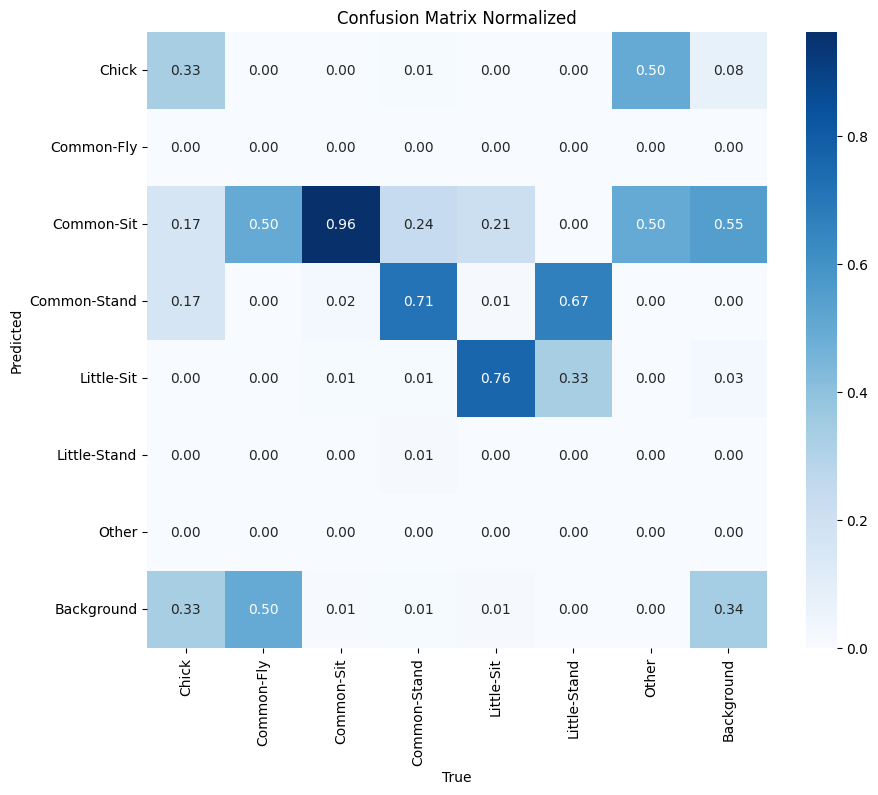

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_values, all_predictions)

class_names = ['Background', 'Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other']

# New order of categories
new_order = ['Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other', 'Background']

# Create a mapping from old order to new order
order_mapping = [class_names.index(name) for name in new_order]

conf_matrix_transposed = conf_matrix.T

# Reorder the confusion matrix
conf_matrix_reordered = conf_matrix_transposed[:, order_mapping][order_mapping, :]

# Normalize the reordered confusion matrix
conf_matrix_normalized = conf_matrix_reordered.astype('float') / conf_matrix_reordered.sum(axis=0)

conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized, nan=0.0)


# Plot the reordered and normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

Evaluate Performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Calculate overall metrics
accuracy = accuracy_score(all_true_values, all_predictions)
precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_values, all_predictions))


Accuracy: 0.90
Precision: 0.90
Recall: 0.90
F1 Score: 0.90

Classification Report:
              precision    recall  f1-score   support

  Background       0.42      0.34      0.38        38
       Chick       0.40      0.33      0.36        12
  Common-Fly       0.00      0.00      0.00         2
  Common-Sit       0.93      0.96      0.95      1431
Common-Stand       0.81      0.71      0.76       221
  Little-Sit       0.81      0.76      0.79        84
Little-Stand       0.00      0.00      0.00         3
       Other       0.00      0.00      0.00         2

    accuracy                           0.90      1793
   macro avg       0.42      0.39      0.40      1793
weighted avg       0.90      0.90      0.90      1793



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Compare YOLO CM with the Random Forest CM

In [ ]:
conf_matrix_normalized_rf = conf_matrix_normalized

zeros_column = np.zeros(8)

# Step 3: Insert the column of zeros after the third column (index 3)
# Axis 1 is for columns, index 3+1 = 4 to insert after the third column
conf_matrix_normalized_rf = np.insert(conf_matrix_normalized_rf, 4, zeros_column, axis=1)

zeros_row = np.zeros(9)

conf_matrix_normalized_rf = np.insert(conf_matrix_normalized_rf, 4, zeros_row, axis=0)

In [ ]:
initial_values_2d = [[0.45, 0, 0, 0.01, 0, 0, 0, 0, 0.08], # Chick
                     [0, 0.37, 0, 0, 0, 0, 0, 0, 0], # Common Fly
                     [0.03, 0, 0.94, 0.19, 0, 0.36, 0.18, 0.5, 0.51], # Common Sit
                     [0.08, 0, 0.03, 0.73, 0, 0, 0.21, 0, 0.25], # Common Stand
                     [0, 0, 0, 0, 0, 0, 0, 0, 0], # Little Fly
                     [0, 0, 0, 0.01, 0, 0.56, 0.25, 0, 0.15], # Little Sit
                     [0, 0, 0, 0, 0, 0.02, 0.18, 0, 0], # Little Stand
                     [0, 0, 0, 0, 0, 0, 0, 0, 0], # Other
                     [0.45, 0.62, 0.03, 0.06, 1.0, 0.06, 0.18, 0.5, 0]] # Background

conf_matrix_normalized_yolo = np.array(initial_values_2d)

conf_matrix_normalized_yolo

array([[0.45, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.08],
       [0.  , 0.37, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.94, 0.19, 0.  , 0.36, 0.18, 0.5 , 0.51],
       [0.08, 0.  , 0.03, 0.73, 0.  , 0.  , 0.21, 0.  , 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.56, 0.25, 0.  , 0.15],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.18, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.45, 0.62, 0.03, 0.06, 1.  , 0.06, 0.18, 0.5 , 0.  ]])

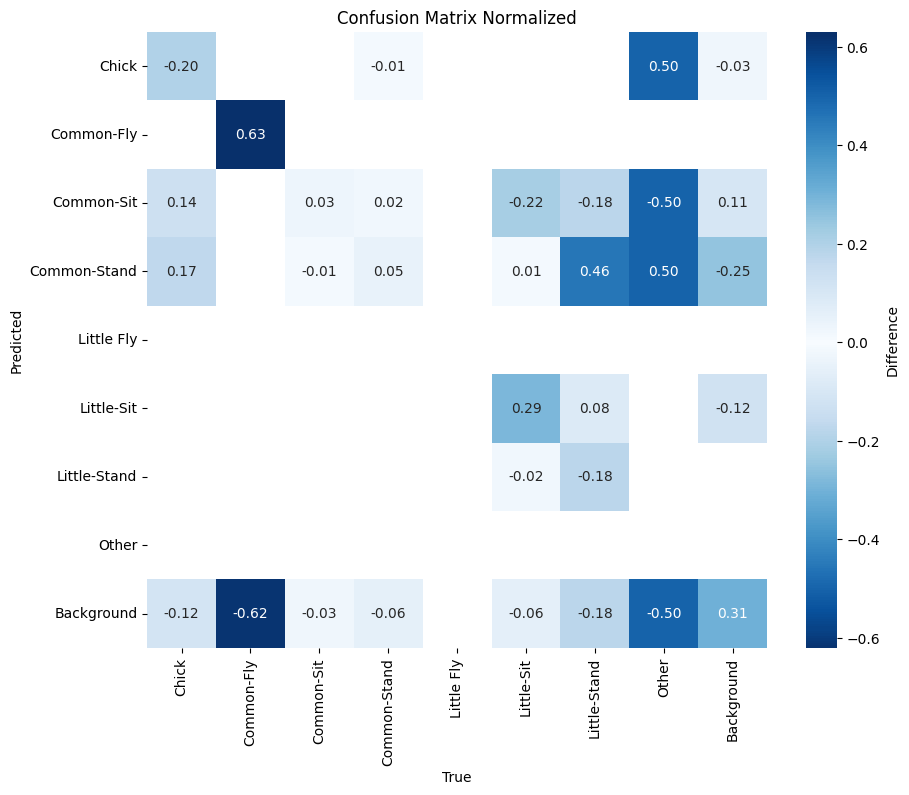

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

difference_matrix = conf_matrix_normalized_rf - conf_matrix_normalized_yolo
# New order of categories
class_names = ['Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little Fly', 'Little-Sit', 'Little-Stand', 'Other', 'Background']

# Assuming conf_matrix_normalized and new_order are already defined
difference_matrix = difference_matrix.astype(np.float64)  # Ensure numeric type
mask = np.zeros_like(difference_matrix, dtype=bool)
mask[(difference_matrix < 0.01) & (difference_matrix > -0.01)] = True

# Create a custom colormap based on the Blues colormap, but symmetric around zero
blues = plt.cm.Blues(np.linspace(0, 1, 256))
newcolors = np.vstack((blues[::-1], blues))
symmetric_blue_cmap = LinearSegmentedColormap.from_list('symmetric_Blues', newcolors)

# Plot the reordered and normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(difference_matrix, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap=symmetric_blue_cmap, center=0, mask=mask, cbar_kws={'label': 'Difference'})
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

In [ ]:
mask = np.zeros_like(conf_matrix_normalized, dtype=bool)
mask[conf_matrix_normalized == 0] = True

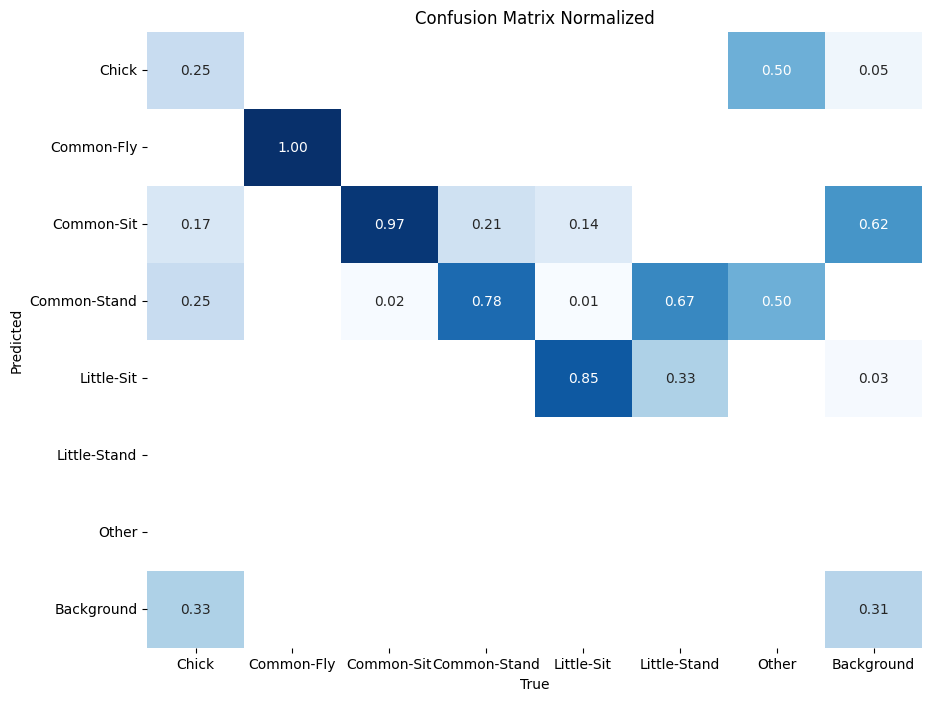

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming conf_matrix_normalized and new_order are already defined
mask = np.zeros_like(conf_matrix_normalized, dtype=bool)
mask[conf_matrix_normalized < 0.01] = True

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues', mask=mask, cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()


### Train Decision Tree with class weights

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier


decisionTreeClassifier = DecisionTreeClassifier(class_weight=dict(zip(np.unique(y), class_weights)))

# Use StratifiedKFold for cross-validation within GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(decisionTreeClassifier, param_grid, cv=cv, scoring='f1_macro')

# Fit the GridSearchCV with cross-validation
grid_search.fit(X, y)

# Get the best model from GridSearchCV
dt_classifier = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# Get the best model from GridSearchCV
dt_classifier = grid_search.best_estimator_

# Display the best hyperparameters
best_hypers = dt_classifier.get_params()
print(f'Hyperparameters: max_depth - {best_hypers["max_depth"]}, min_samples_split - {best_hypers["min_samples_split"]}')

Hyperparameters: max_depth - None, min_samples_split - 2


In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

# Initialize variables to accumulate results
all_predictions = np.array([])
all_true_values = np.array([])

# Create DecisionTreeClassifier with class weights
dt_classifier = DecisionTreeClassifier(class_weight=dict(zip(np.unique(y), class_weights)), max_depth=best_hypers["max_depth"], min_samples_split=best_hypers["min_samples_split"])

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the decisionTreeClassifier
    dt_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = dt_classifier.predict(X_test)

    # Accumulate the results
    all_predictions = np.concatenate([all_predictions, y_pred])
    all_true_values = np.concatenate([all_true_values, y_test])

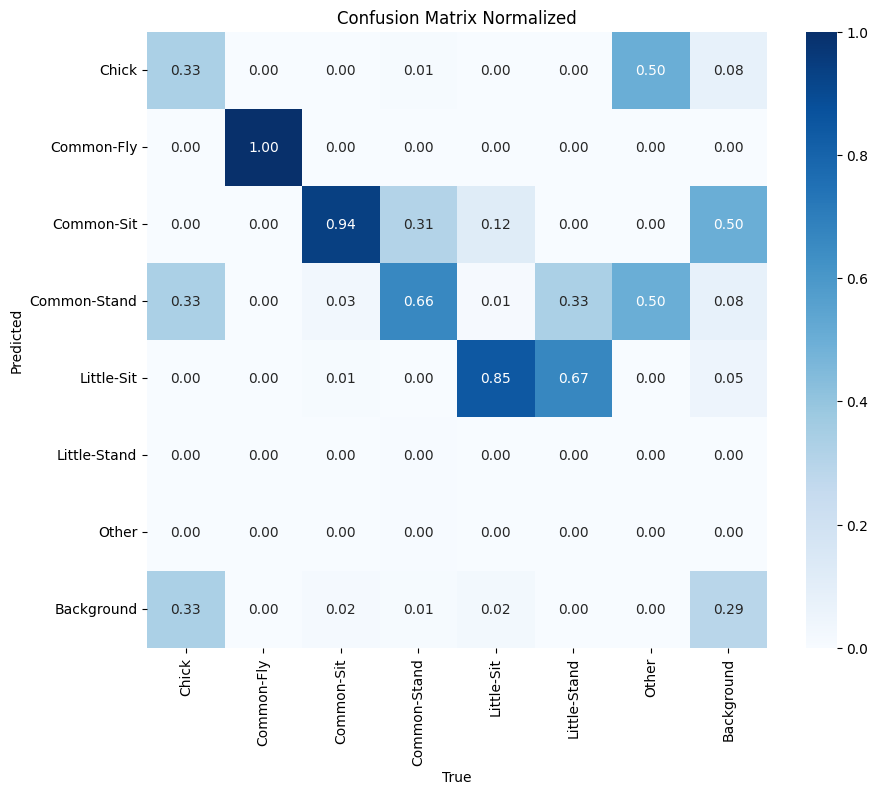

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_values, all_predictions)


class_names = ['Background', 'Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other']

# New order of categories
new_order = ['Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other', 'Background']

# Create a mapping from old order to new order
order_mapping = [class_names.index(name) for name in new_order]

conf_matrix_transposed = conf_matrix.T

# Reorder the confusion matrix
conf_matrix_reordered = conf_matrix_transposed[:, order_mapping][order_mapping, :]

# Normalize the reordered confusion matrix
conf_matrix_normalized = conf_matrix_reordered.astype('float') / conf_matrix_reordered.sum(axis=0)

conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized, nan=0.0)


# Plot the reordered and normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Calculate overall metrics
accuracy = accuracy_score(all_true_values, all_predictions)
precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_values, all_predictions))


Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88

Classification Report:
              precision    recall  f1-score   support

  Background       0.24      0.29      0.26        38
       Chick       0.33      0.33      0.33        12
  Common-Fly       1.00      1.00      1.00         2
  Common-Sit       0.93      0.94      0.94      1431
Common-Stand       0.72      0.66      0.69       221
  Little-Sit       0.82      0.85      0.83        84
Little-Stand       0.00      0.00      0.00         3
       Other       0.00      0.00      0.00         2

    accuracy                           0.88      1793
   macro avg       0.51      0.51      0.51      1793
weighted avg       0.88      0.88      0.88      1793



## Train Random Forest without class weights

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier


rf_classifier = RandomForestClassifier()

# Use StratifiedKFold for cross-validation within GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, scoring='f1_macro')

# Fit the GridSearchCV with cross-validation
grid_search.fit(X, y)

# Get the best model from GridSearchCV
dt_classifier = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# Get the best model from GridSearchCV
rf_classifier = grid_search.best_estimator_

# Display the best hyperparameters
best_hypers = rf_classifier.get_params()
print(f'Hyperparameters: max_depth - {best_hypers["max_depth"]}, min_samples_split - {best_hypers["min_samples_split"]}')

Hyperparameters: max_depth - 7, min_samples_split - 2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


# Initialize variables to accumulate results
all_predictions = np.array([])
all_true_values = np.array([])

# Initialize your model
rf = RandomForestClassifier(max_depth=best_hypers["max_depth"], min_samples_split=best_hypers["min_samples_split"])

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Random Forest classifier
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Accumulate the results
    all_predictions = np.concatenate([all_predictions, y_pred])
    all_true_values = np.concatenate([all_true_values, y_test])

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_values, all_predictions)

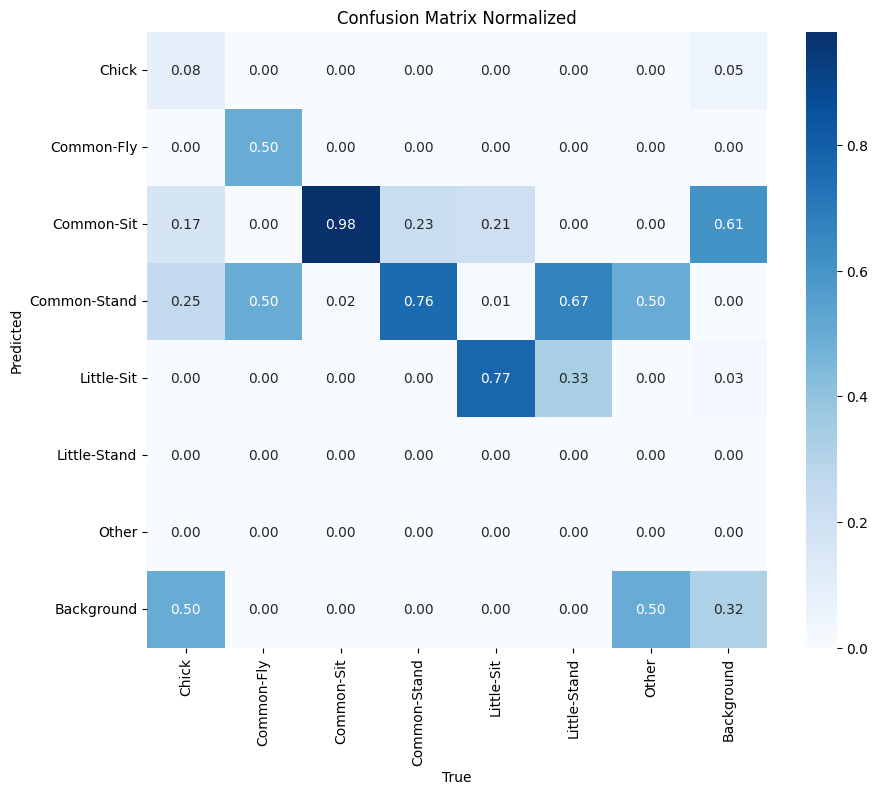

In [ ]:
class_names = ['Background', 'Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other']

# New order of categories
new_order = ['Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other', 'Background']

# Create a mapping from old order to new order
order_mapping = [class_names.index(name) for name in new_order]

conf_matrix_transposed = conf_matrix.T

# Reorder the confusion matrix
conf_matrix_reordered = conf_matrix_transposed[:, order_mapping][order_mapping, :]

# Normalize the reordered confusion matrix
conf_matrix_normalized = conf_matrix_reordered.astype('float') / conf_matrix_reordered.sum(axis=0)

conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized, nan=0.0)


# Plot the reordered and normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Calculate overall metrics
accuracy = accuracy_score(all_true_values, all_predictions)
precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_values, all_predictions))

Accuracy: 0.92
Precision: 0.91
Recall: 0.92
F1 Score: 0.91

Classification Report:
              precision    recall  f1-score   support

  Background       0.60      0.32      0.41        38
       Chick       0.33      0.08      0.13        12
  Common-Fly       1.00      0.50      0.67         2
  Common-Sit       0.94      0.98      0.96      1431
Common-Stand       0.84      0.76      0.80       221
  Little-Sit       0.88      0.77      0.82        84
Little-Stand       0.00      0.00      0.00         3
       Other       0.00      0.00      0.00         2

    accuracy                           0.92      1793
   macro avg       0.57      0.43      0.47      1793
weighted avg       0.91      0.92      0.91      1793



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Train Random Forest with class weights

In [ ]:
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y), class_weights)))

# Use StratifiedKFold for cross-validation within GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=cv, scoring='f1_macro')

# Fit the GridSearchCV with cross-validation
grid_search.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight={'Background': 5.8980263157894735,
                                                            'Chick': 18.677083333333332,
                                                            'Common-Fly': 112.0625,
                                                            'Common-Sit': 0.15662124388539483,
                                                            'Common-Stand': 1.0141402714932126,
                                                            'Little-Sit': 2.668154761904762,
                                                            'Little-Stand': 74.70833333333333,
                                                            'Other': 112.0625}),
             param_grid={'max_depth': [None, 3, 5, 7, 9],
                         'min_samples_split': [2, 5, 7]},
             scoring='f1_macro')

In [ ]:
# Get the best model from GridSearchCV
rf_classifier = grid_search.best_estimator_

# Display the best hyperparameters
best_hypers = rf_classifier.get_params()
print(f'Hyperparameters: max_depth - {best_hypers["max_depth"]}, min_samples_split - {best_hypers["min_samples_split"]}')

Hyperparameters: max_depth - 9, min_samples_split - 7


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier


# Initialize variables to accumulate results
all_predictions = np.array([])
all_true_values = np.array([])

# Initialize your model
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y), class_weights)), \
                    max_depth=best_hypers["max_depth"], min_samples_split=best_hypers["min_samples_split"])

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Random Forest Classifier
    rf_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_classifier.predict(X_test)

    # Accumulate the results
    all_predictions = np.concatenate([all_predictions, y_pred])
    all_true_values = np.concatenate([all_true_values, y_test])

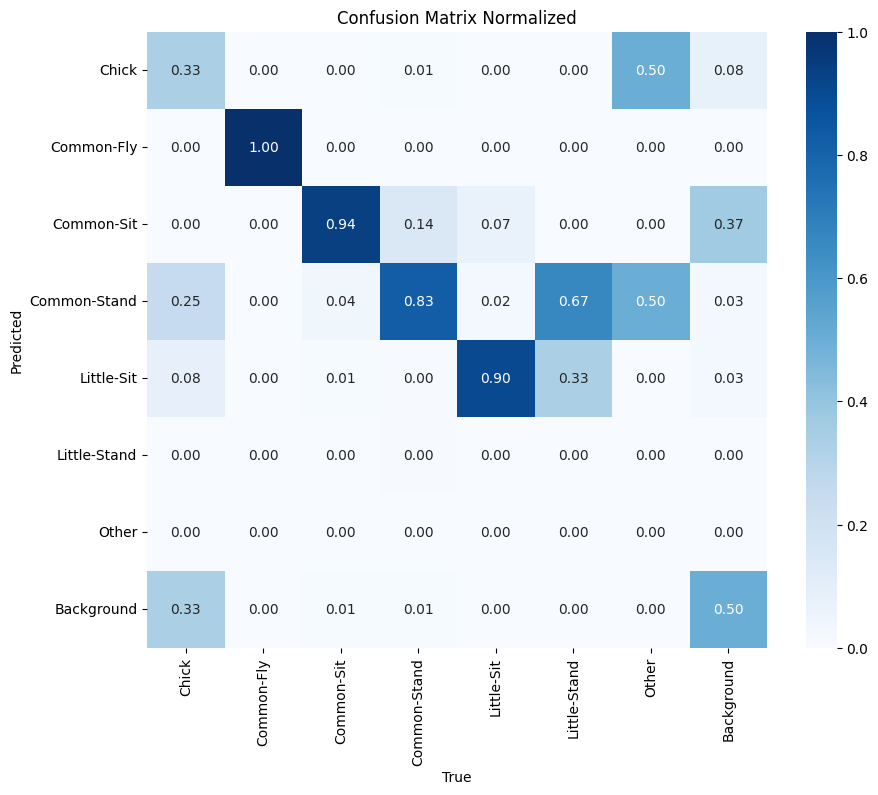

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_values, all_predictions)

class_names = ['Background', 'Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other']

# New order of categories
new_order = ['Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other', 'Background']

# Create a mapping from old order to new order
order_mapping = [class_names.index(name) for name in new_order]

conf_matrix_transposed = conf_matrix.T

# Reorder the confusion matrix
conf_matrix_reordered = conf_matrix_transposed[:, order_mapping][order_mapping, :]

# Normalize the reordered confusion matrix
conf_matrix_normalized = conf_matrix_reordered.astype('float') / conf_matrix_reordered.sum(axis=0)

conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized, nan=0.0)


# Plot the reordered and normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Calculate overall metrics
accuracy = accuracy_score(all_true_values, all_predictions)
precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_values, all_predictions))

Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91

Classification Report:
              precision    recall  f1-score   support

  Background       0.49      0.50      0.49        38
       Chick       0.36      0.33      0.35        12
  Common-Fly       1.00      1.00      1.00         2
  Common-Sit       0.96      0.94      0.95      1431
Common-Stand       0.73      0.83      0.78       221
  Little-Sit       0.82      0.90      0.86        84
Little-Stand       0.00      0.00      0.00         3
       Other       0.00      0.00      0.00         2

    accuracy                           0.91      1793
   macro avg       0.55      0.56      0.55      1793
weighted avg       0.91      0.91      0.91      1793



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Run Cross Validation on Neural Network(without class weights)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV


# Define the parameter grid for the neural network
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Hidden layers
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimizer
    'alpha': [0.0001, 0.001],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01],  # Initial learning rate
    'max_iter': [200]  # Iterations
}

# Initialize the MLPClassifier
mlp_classifier = MLPClassifier(random_state=42)

# Use StratifiedKFold for cross-validation within GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=cv, scoring='f1_macro')

# Fit the GridSearchCV with cross-validation
grid_search.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

In [ ]:
# Get the best model from GridSearchCV
mlp_classifier = grid_search.best_estimator_

# Display the best hyperparameters
best_hypers = mlp_classifier.get_params()
# print(f'Hyperparameters: max_depth - {best_hypers["max_depth"]}, min_samples_split - {best_hypers["min_samples_split"]}')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

# Initialize variables to accumulate results
all_predictions = np.array([])
all_true_values = np.array([])

# Initialize your MLPClassifier model with the best hyperparameters found
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=best_hypers["hidden_layer_sizes"],
    activation=best_hypers["activation"],
    solver=best_hypers["solver"],
    alpha=best_hypers["alpha"],
    learning_rate_init=best_hypers["learning_rate_init"],
    max_iter=best_hypers["max_iter"],
    random_state=42
)

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the MLPClassifier
    mlp_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = mlp_classifier.predict(X_test)

    # Accumulate the results
    all_predictions = np.concatenate([all_predictions, y_pred])
    all_true_values = np.concatenate([all_true_values, y_test])

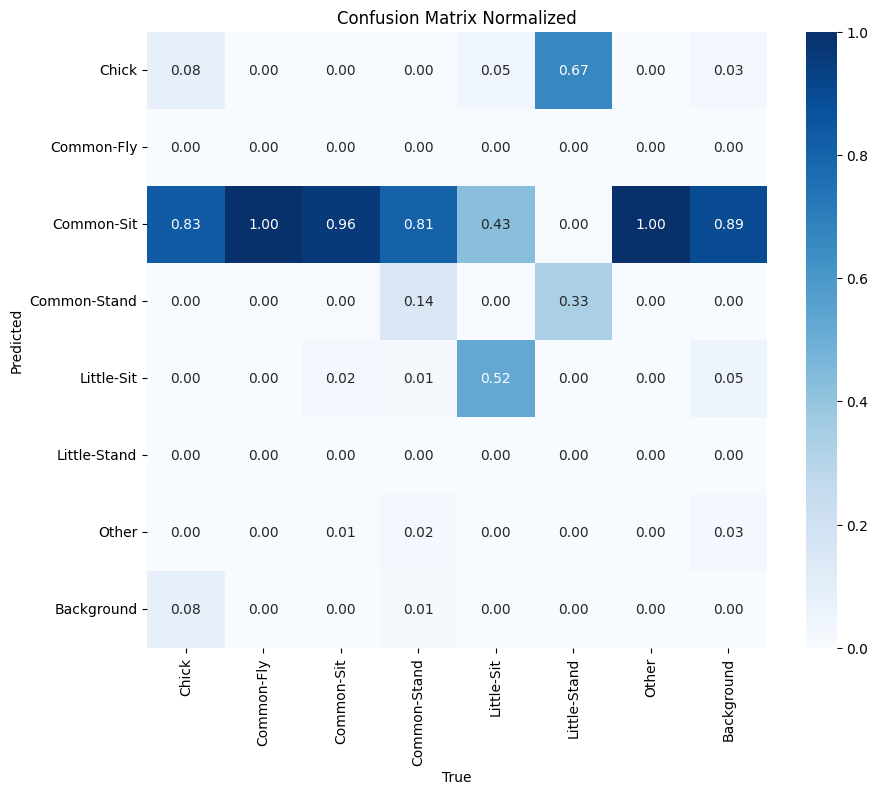

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_values, all_predictions)

class_names = ['Background', 'Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other']

# New order of categories
new_order = ['Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other', 'Background']

# Create a mapping from old order to new order
order_mapping = [class_names.index(name) for name in new_order]

conf_matrix_transposed = conf_matrix.T

# Reorder the confusion matrix
conf_matrix_reordered = conf_matrix_transposed[:, order_mapping][order_mapping, :]

# Normalize the reordered confusion matrix
conf_matrix_normalized = conf_matrix_reordered.astype('float') / conf_matrix_reordered.sum(axis=0)

conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized, nan=0.0)


# Plot the reordered and normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Calculate overall metrics
accuracy = accuracy_score(all_true_values, all_predictions)
precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_values, all_predictions))


Accuracy: 0.81
Precision: 0.80
Recall: 0.81
F1 Score: 0.77

Classification Report:
              precision    recall  f1-score   support

  Background       0.00      0.00      0.00        38
       Chick       0.11      0.08      0.10        12
  Common-Fly       0.00      0.00      0.00         2
  Common-Sit       0.84      0.96      0.90      1431
Common-Stand       0.82      0.14      0.25       221
  Little-Sit       0.56      0.52      0.54        84
Little-Stand       0.00      0.00      0.00         3
       Other       0.00      0.00      0.00         2

    accuracy                           0.81      1793
   macro avg       0.29      0.21      0.22      1793
weighted avg       0.80      0.81      0.77      1793



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Run Cross Validation on Neural Network(with class weights)

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

rus = RandomOverSampler(sampling_strategy='all', random_state=1)
X_balanced, y_balanced = rus.fit_resample(X, y)

In [ ]:
len(y_balanced)

11448

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier


# Define the parameter grid for the neural network
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Hidden layers
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimizer
    'alpha': [0.0001, 0.001],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01],  # Initial learning rate
    'max_iter': [200]  # Iterations
}

# Initialize the MLPClassifier
mlp_classifier = MLPClassifier(random_state=42)

# Use StratifiedKFold for cross-validation within GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(mlp_classifier, param_grid, cv=cv, scoring='f1_macro')

# Fit the GridSearchCV with cross-validation
grid_search.fit(X_balanced, y_balanced)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                         'learning_rate_init': [0.001, 0.01], 'max_iter': [200],
                         'solver': ['adam', 'sgd']},
             scoring='f1_macro')

In [ ]:
# Get the best model from GridSearchCV
mlp_classifier = grid_search.best_estimator_

# Display the best hyperparameters
best_hypers = mlp_classifier.get_params()

best_hypers

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

# Initialize variables to accumulate results
all_predictions = np.array([])
all_true_values = np.array([])

# Initialize your MLPClassifier model with the best hyperparameters found
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=best_hypers["hidden_layer_sizes"],
    activation=best_hypers["activation"],
    solver=best_hypers["solver"],
    alpha=best_hypers["alpha"],
    learning_rate_init=best_hypers["learning_rate_init"],
    max_iter=best_hypers["max_iter"],
    random_state=42
)

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rus = RandomOverSampler(sampling_strategy='all', random_state=1)
    balanced_X_train, balanced_y_train = rus.fit_resample(X_train, y_train)

    # Train the MLPClassifier
    mlp_classifier.fit(balanced_X_train, balanced_y_train)

    # Make predictions
    y_pred = mlp_classifier.predict(X_test)

    # Accumulate the results
    all_predictions = np.concatenate([all_predictions, y_pred])
    all_true_values = np.concatenate([all_true_values, y_test])

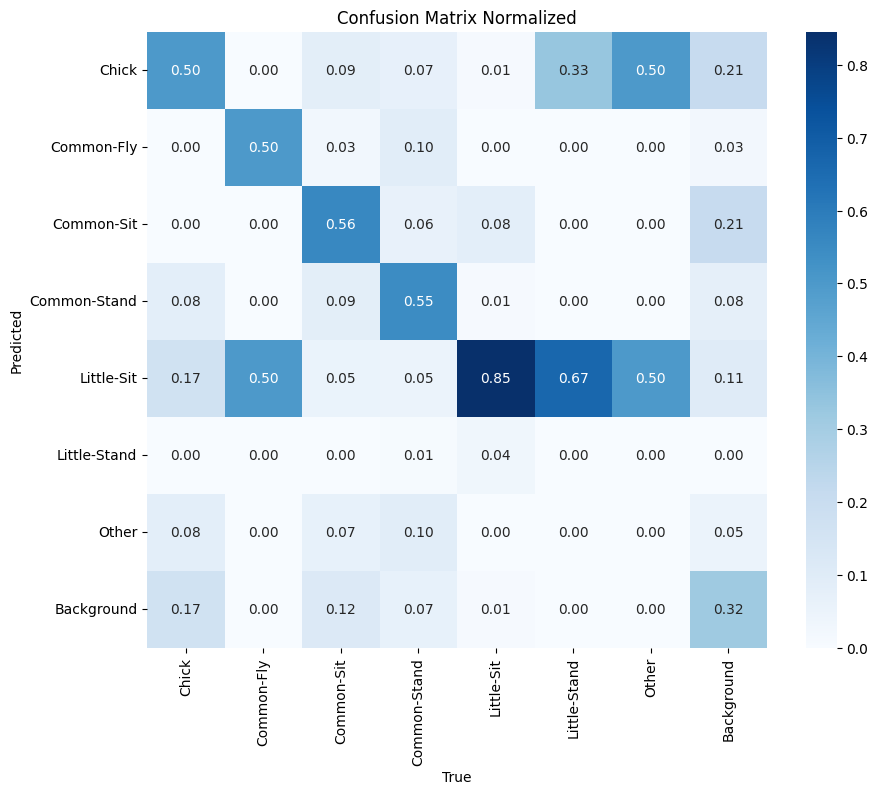

In [ ]:
conf_matrix_normalized = confusion_matrix(all_true_values, all_predictions, labels=classes, normalize='true')
conf_matrix_normalized = conf_matrix_normalized.T

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized_new, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

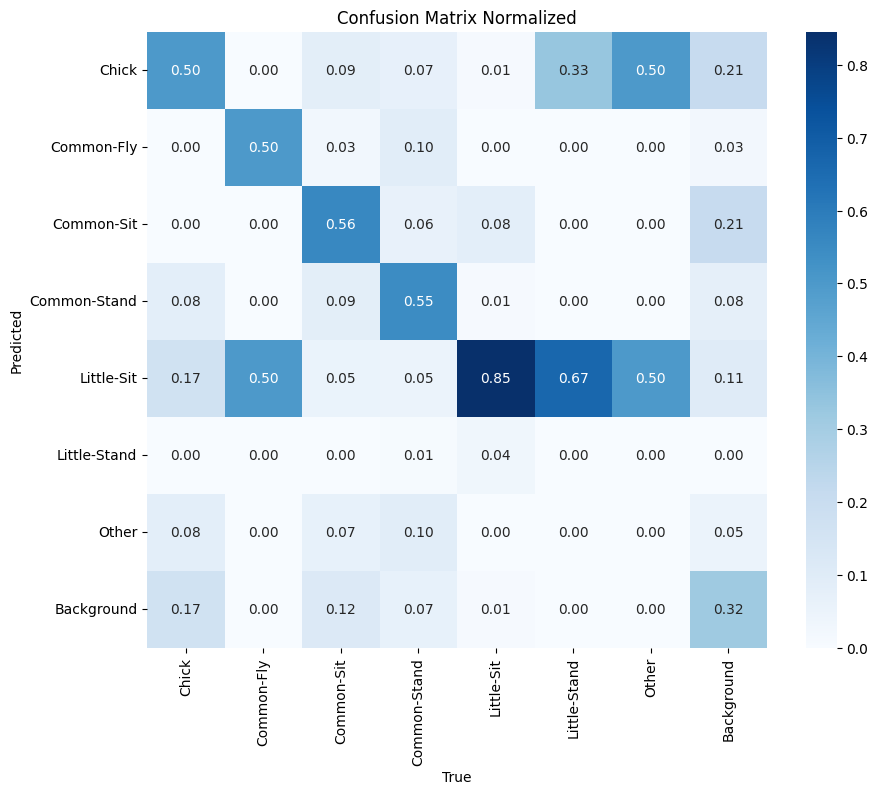

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_values, all_predictions)

class_names = ['Background', 'Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other']

# New order of categories
new_order = ['Chick', 'Common-Fly', 'Common-Sit', 'Common-Stand', 'Little-Sit', 'Little-Stand', 'Other', 'Background']

# Create a mapping from old order to new order
order_mapping = [class_names.index(name) for name in new_order]

conf_matrix_transposed = conf_matrix.T

# Reorder the confusion matrix
conf_matrix_reordered = conf_matrix_transposed[:, order_mapping][order_mapping, :]

# Normalize the reordered confusion matrix
conf_matrix_normalized = conf_matrix_reordered.astype('float') / conf_matrix_reordered.sum(axis=0)

conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized, nan=0.0)


# Plot the reordered and normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=new_order, yticklabels=new_order, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix Normalized')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Calculate overall metrics
accuracy = accuracy_score(all_true_values, all_predictions)
precision = precision_score(all_true_values, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_true_values, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_true_values, all_predictions, average='weighted', zero_division=0)

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_true_values, all_predictions))

Accuracy: 0.56
Precision: 0.85
Recall: 0.56
F1 Score: 0.66

Classification Report:
              precision    recall  f1-score   support

  Background       0.06      0.32      0.10        38
       Chick       0.04      0.50      0.07        12
  Common-Fly       0.02      0.50      0.03         2
  Common-Sit       0.96      0.56      0.71      1431
Common-Stand       0.48      0.55      0.51       221
  Little-Sit       0.42      0.85      0.56        84
Little-Stand       0.00      0.00      0.00         3
       Other       0.00      0.00      0.00         2

    accuracy                           0.56      1793
   macro avg       0.25      0.41      0.25      1793
weighted avg       0.85      0.56      0.66      1793



In [ ]:
import numpy as np
import pandas as pd

# Given confusion matrix
confusion_matrix = np.array([
    [0.45, 0, 0, 0.01, 0, 0, 0, 0, 0.08],
    [0, 0.37, 0, 0, 0, 0, 0, 0, 0],
    [0.03, 0, 0.94, 0.19, 0, 0.36, 0.18, 0.5, 0.51],
    [0.08, 0, 0.03, 0.73, 0, 0, 0.21, 0, 0.25],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0.01, 0, 0.56, 0.25, 0, 0.15],
    [0, 0, 0, 0, 0, 0.02, 0.18, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0.45, 0.62, 0.03, 0.06, 1, 0.06, 0.18, 0.5, 0]
])

# Categories
categories = [
    "Background", "Chick", "Common-Fly", "Common-Sit",
    "Common-Stand", "Little-Fly", "Little-Sit", "Little-Stand", "Other"
]

# Initialize metrics
precision = []
recall = []
f1_score = []
support = []

# Calculate metrics for each category
for i, category in enumerate(categories):
    TP = confusion_matrix[i, i]
    FP = confusion_matrix[:, i].sum() - TP
    FN = confusion_matrix[i, :].sum() - TP
    TN = confusion_matrix.sum() - (TP + FP + FN)

    precision_value = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_value = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_value = (2 * precision_value * recall_value) / (precision_value + recall_value) if (precision_value + recall_value) > 0 else 0
    support_value = confusion_matrix[i, :].sum()

    precision.append(precision_value)
    recall.append(recall_value)
    f1_score.append(f1_value)
    support.append(support_value)

# Overall accuracy
total_correct = np.trace(confusion_matrix)
total_samples = confusion_matrix.sum()
accuracy = total_correct / total_samples

# Macro Avg
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1_score)

# Weighted Avg
weights = np.array(support) / total_samples
weighted_precision = np.sum(precision * weights)
weighted_recall = np.sum(recall * weights)
weighted_f1 = np.sum(f1_score * weights)

# Create the dataframe
results = pd.DataFrame({
    "Category": categories + ["Accuracy", "Macro Avg", "Weighted Avg"],
    "Precision": precision + [accuracy, macro_precision, weighted_precision],
    "Recall": recall + [accuracy, macro_recall, weighted_recall],
    "F1-Score": f1_score + [accuracy, macro_f1, weighted_f1],
    "Support": support + ["", "", ""]
})

results


,Category,Precision,Recall,F1-Score,Support
0,Background,0.445545,0.357143,0.396476,1.26
1,Chick,0.373737,1.000000,0.544118,0.37
2,Common-Fly,0.940000,0.346863,0.506739,2.71
3,Common-Sit,0.730000,0.561538,0.634783,1.3
4,Common-Stand,0.000000,0.000000,0.000000,0.0
5,Little-Fly,0.560000,0.577320,0.568528,0.97
6,Little-Sit,0.180000,0.900000,0.300000,0.2
7,Little-Stand,0.000000,0.000000,0.000000,0.0
8,Other,0.000000,0.000000,0.000000,2.9
9,Accuracy,0.332647,0.332647,0.332647,


### After evaluating the performance of various classifiers through cross-validation, we selected the Random Forest classifier trained with class weights. We will now train this classifier with the Hyperparameters chosen on the entire dataset.


In [ ]:
best_hypers = {
    'max_depth': 9, 'min_samples_split': 7
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight


# Initialize your model
rf_classifier = RandomForestClassifier(class_weight=dict(zip(np.unique(y), class_weights)), \
                    max_depth=best_hypers["max_depth"], min_samples_split=best_hypers["min_samples_split"])

rf_classifier.fit(X, y)

RandomForestClassifier(class_weight={'Background': 5.8980263157894735,
                                     'Chick': 18.677083333333332,
                                     'Common-Fly': 112.0625,
                                     'Common-Sit': 0.15662124388539483,
                                     'Common-Stand': 1.0141402714932126,
                                     'Little-Sit': 2.668154761904762,
                                     'Little-Stand': 74.70833333333333,
                                     'Other': 112.0625},
                       max_depth=9, min_samples_split=7)

### Save the Random Forest and Decision Tree Classifiers.

In [ ]:
!pip install joblib

Saving the Random Forest and Decision Tree models trained with class weights on Drive.

In [ ]:
import joblib

classifiers_dir = '/content/drive/MyDrive/tern_project/Eyal/ClassifyTerns/TrainingModel'

# Save Decision Tree model(wit class-weights)
joblib.dump(rf_classifier, f'{classifiers_dir}/rf_weights_model.pkl')

['/content/drive/MyDrive/tern_project/Eyal/ClassifyTerns/TrainingModel/rf_weights_model_v2.pkl']

Display features importancy according to the trained Random Forest classifier

In [ ]:
sorted_importances

array([9.42723062e-02, 9.30773931e-02, 7.81922008e-02, 7.77927901e-02,
       7.37226065e-02, 6.76386354e-02, 5.88459270e-02, 5.85112106e-02,
       5.84726118e-02, 5.38575996e-02, 4.66652759e-02, 4.38253557e-02,
       4.35925865e-02, 4.17158184e-02, 3.28255085e-02, 3.27934029e-02,
       2.05076324e-02, 1.63718196e-02, 6.72196571e-03, 4.30565761e-04,
       1.53426458e-04, 1.33608937e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

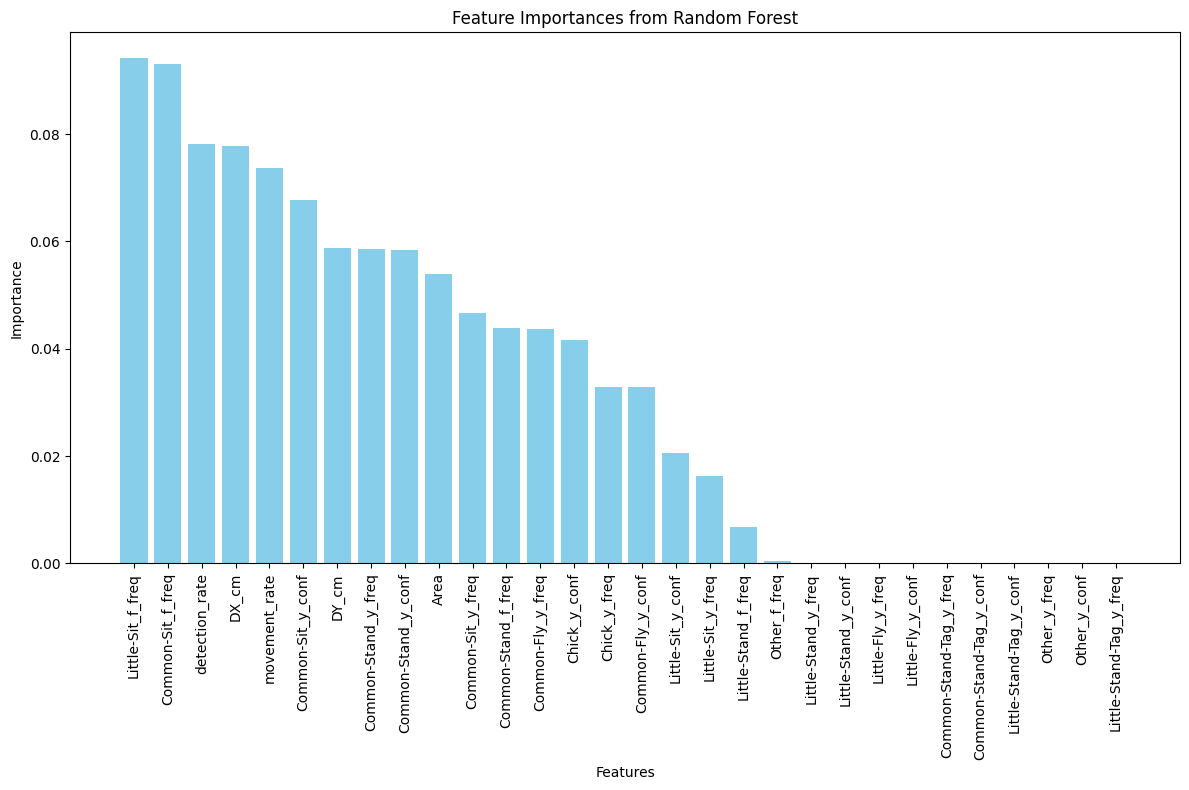

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume X.columns contains the feature names
feature_names = X.columns  # Feature names
importances = rf_classifier.feature_importances_  # Feature importances from the classifier

# Sort the features by importance
indices = np.argsort(importances)[::-1]  # Indices of features sorted by importance
sorted_feature_names = feature_names[indices]
sorted_importances = importances[indices]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center', color='skyblue')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()